In [1]:
import os, sys, time, copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import multiprocessing
from functools import partial
from tqdm import tqdm

import collections
from typing import List

import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy
import vc_protocols

In [2]:
# VC_protocol = vc_protocols.hERG_CiPA()
# VC_protocol = vc_protocols.cav12_CiPA()
# VC_protocol = vc_protocols.lateNav15_CiPA()

VC_protocol = protocol_lib.VoltageClampProtocol()  # steps=steps
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-90, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-35, duration=40) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-40, duration=40) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=40) )  # <- why?? vo
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=40, duration=500) )
VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=40, voltage_end=-120, duration=200)) # ramp step
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=100) )
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=60, duration=500) )
# VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=60, voltage_end=-80, duration=200)) # ramp step

vhold = VC_protocol.steps[0].voltage

print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} ms')

The protocol is 1320 ms


In [3]:
gen_params = {
    'end_time': VC_protocol.get_voltage_change_endpoints()[-1],                            
    'log_li' : ['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ical.ICaNa', 'ical.ICaK', 'ikr.IKr', 'iks.IKs', 'ik1.IK1', 'inaca.INaCa', 'inacass.INaCa_ss', 'inak.INaK', 'ikb.IKb', 'inab.INab', 'icab.ICab', 'ipca.IpCa'],
    'save_log_li' : ['ina.INa', 'ikr.IKr', 'iks.IKs', 'ito.Ito', 'ical.ICaL',  'ik1.IK1', 'inal.INaL'],
    'nData' : 5,                         
    'dataset_dir' : '../../Dataset/ohara2017_LeemV1_fixed_concentrations',
    'data_file_name' : 'currents',
    'window' : 10,
    'step_size' : 5,
}  
# gen_params['dataset_dir'] = gen_params['dataset_dir'] + f"_w{gen_params['window']}_s{gen_params['step_size']}"
print( gen_params['dataset_dir'] )
cell_types = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}

ds_params = {
    'window' : 20,
    'step_size' : 10,   
    'window_type' : 'amax',
    'noise_sigma' : 0
}  

sys.path.append(gen_params['dataset_dir'])
from agetdata import get_dataset, get_dataset2, get_currents_with_constant_dt

../../Dataset/ohara2017_LeemV1_fixed_concentrations


In [4]:
xs, ys = get_dataset2( file_numbers=range(1, 11), window=0, step_size=0, window_type=ds_params['window_type'],  multi=True, torch_tensor=False)
print(xs.shape, ys.shape)

100%|████████████████████████████████████████| 10/10 [00:00<00:00, 47339.77it/s]

--- 9.201587200164795 seconds ---
(100000, 2) (100000, 7)


In [5]:
start_time = time.time()

model, p, s = myokit.load("../mmt-model-files/ohara-cipa-v1-2017_fixedconc-v1.mmt")    
sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=-80)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "ohara2017"  

f = 1.5
model_params = {         
    'cell.mode': cell_types['Mid-myocardial'],
    'setting.simType': 1,   # 0: AP   |  1: VC  
    
    'ina.gNa' : 75.0 * f,   
    'inal.gNaL' : 0.0075 * 2.661 * f,  
    'ito.gto' : 0.02 * 4 * f,
    'ical.PCa' : 0.0001 * 1.007 * 2.5 * f,
    'ikr.gKr' : 4.65854545454545618e-2 * 1.3 * f, # [mS/uF]
    'iks.gKs' : 0.0034 * 1.87 * 1.4 * f,
    'ik1.gK1' : 0.1908 * 1.698 * 1.3 * f,
    'inaca.gNaCa' : 0.0008 * 1.4,
    'inak.PNaK' : 30 * 0.7,
    'ikb.gKb' : 0.003,
    'inab.PNab' : 3.75e-10,
    'icab.PCab' : 2.5e-8,
    'ipca.GpCa' : 0.0005,
}
sim.set_simulation_params(model_params)

print("--- %s seconds ---"%(time.time()-start_time))

--- 4.456992149353027 seconds ---


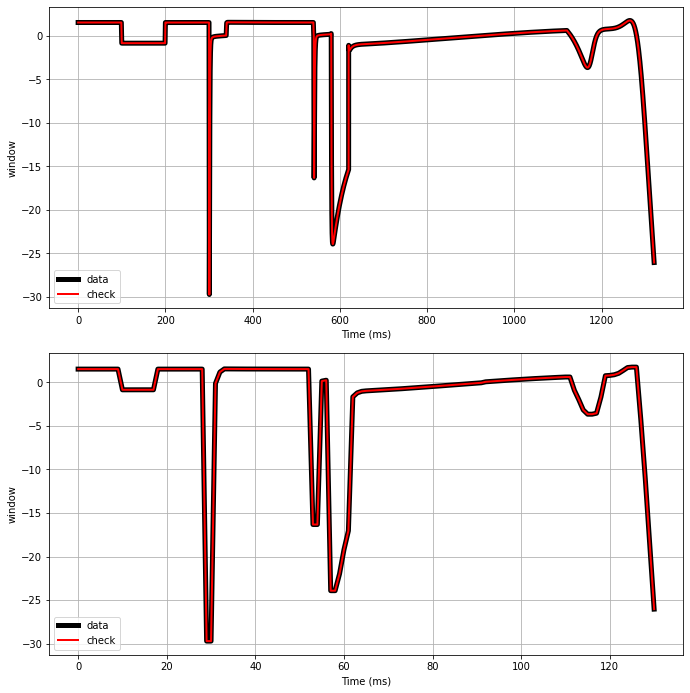

In [22]:
dataNo = 0
    
sol1 = {}
sol1["Time"] = xs[dataNo][0]
sol1["I_ion"] = xs[dataNo][1]
sol1["window"] = get_currents_with_constant_dt(params=ds_params, x=[sol1["Time"], sol1["I_ion"]])
y = ys[dataNo]

# sol1 = pd.DataFrame(data=sol1)
# sol1.head()

g_adj_li= {
    'ina.g_adj' : y[0],
    'inal.g_adj' : y[1],
    'ito.g_adj' : y[2],
    'ical.g_adj' : y[3],
    'ikr.g_adj' : y[4],
    'iks.g_adj' : y[5],    
    'ik1.g_adj' : y[6],
} 
sim.set_simulation_params(g_adj_li)  

sim.pre_simulate(5000, sim_type=1)
d = sim.simulate( gen_params['end_time'], extra_log=['membrane.VC', 'membrane.i_ion']+gen_params['log_li'])                           

sol2 = {}
sol2["Time"] = d['engine.time']
# sol2["Voltage"] = d['membrane.VC']
sol2["I_ion"] = d['membrane.i_ion'] #+ np.random.normal(0, 2, d['membrane.i_ion'].shape) # add noise
sol2["window"] = get_currents_with_constant_dt(params=ds_params, x=[sol2["Time"], sol2["I_ion"]])
# sol2["I_Na"] = sim.current_response_info.get_current(['INa'])
# sol2["I_NaL"] = sim.current_response_info.get_current(['INaL'])
# sol2["I_To"] = sim.current_response_info.get_current(['Ito'])
# sol2["I_CaL"] = sim.current_response_info.get_current(['ICaL'])
# sol2["I_Kr"] = sim.current_response_info.get_current(['IKr'])
# sol2["I_Ks"] = sim.current_response_info.get_current(['IKs'])
# sol2["I_K1"] = sim.current_response_info.get_current(['IK1'])
# sol2 = pd.DataFrame(data=sol2)
# sol2.head()
# np.random.normal(0, noise_sigma, current.shape) # add noise

'''
Plot
'''
fig, ax = plt.subplots(2,1, figsize=(10,10))    

ax[0].set_xlabel('Time (ms)')       
ax[0].set_ylabel(f'{name}')      
ax[0].plot( sol1['Time'], sol1['I_ion'], label='data', color='k', linewidth=5)     
ax[0].plot( sol2['Time'], sol2['I_ion'], label='check', color='r', linewidth=2)    
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel('Time (ms)')       
ax[1].set_ylabel(f'{name}')      
ax[1].plot( sol1['window'], label='data', color='k', linewidth=5)     
ax[1].plot( sol2['window'], label='check', color='r', linewidth=2)    
ax[1].legend()
ax[1].grid()


# ax[-1].set_ylim(-5, 5)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)    
# fig.savefig(os.path.join('Test_results', f"{dataNo}.jpg"), dpi=100)
plt.show()    

finish


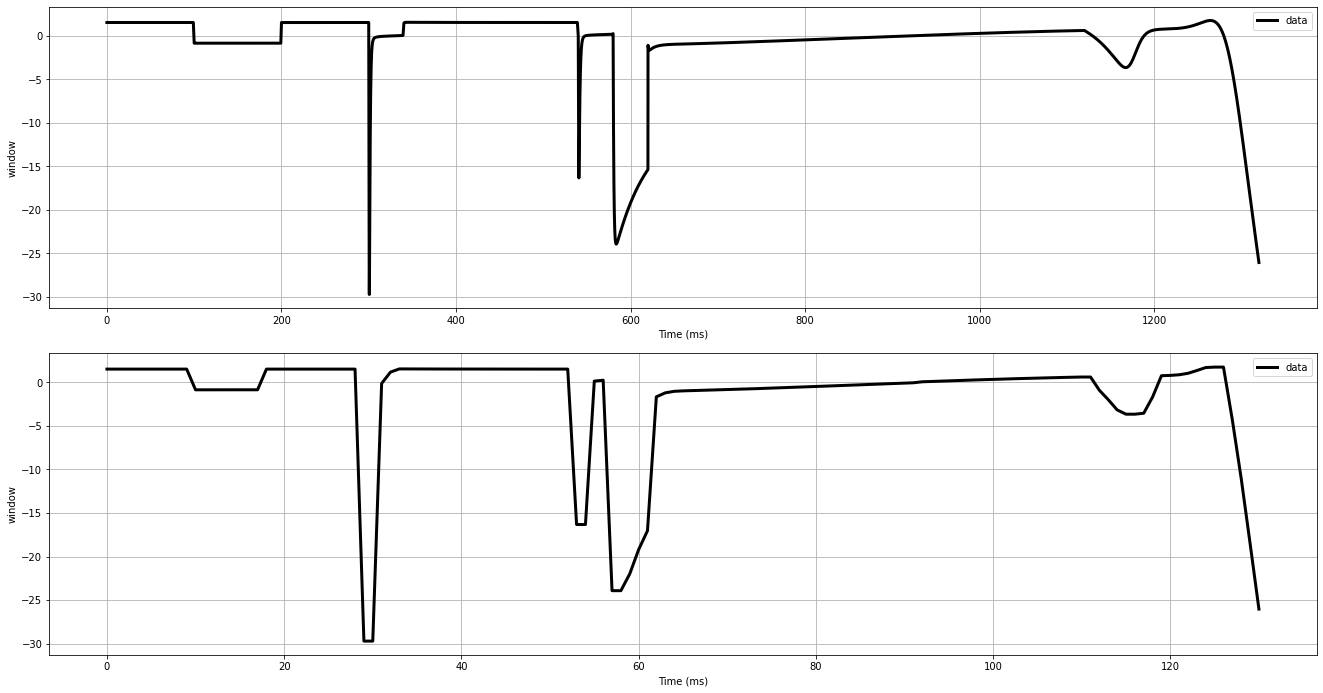

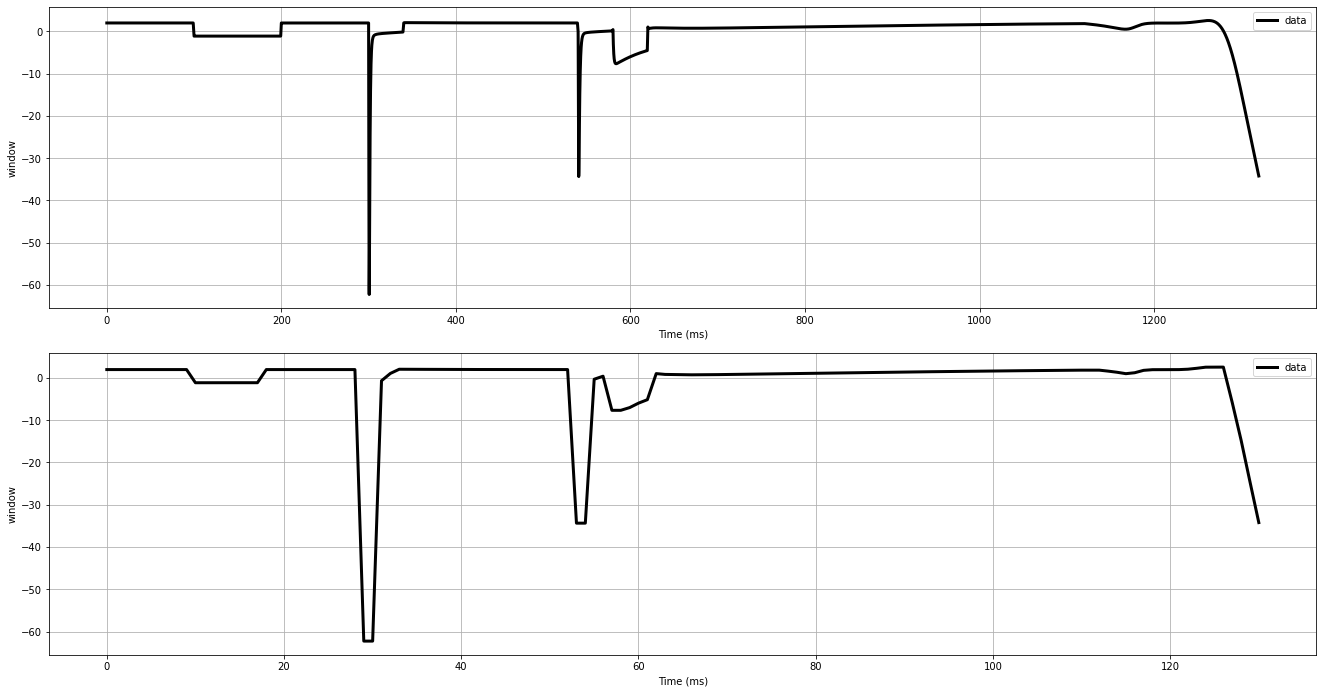

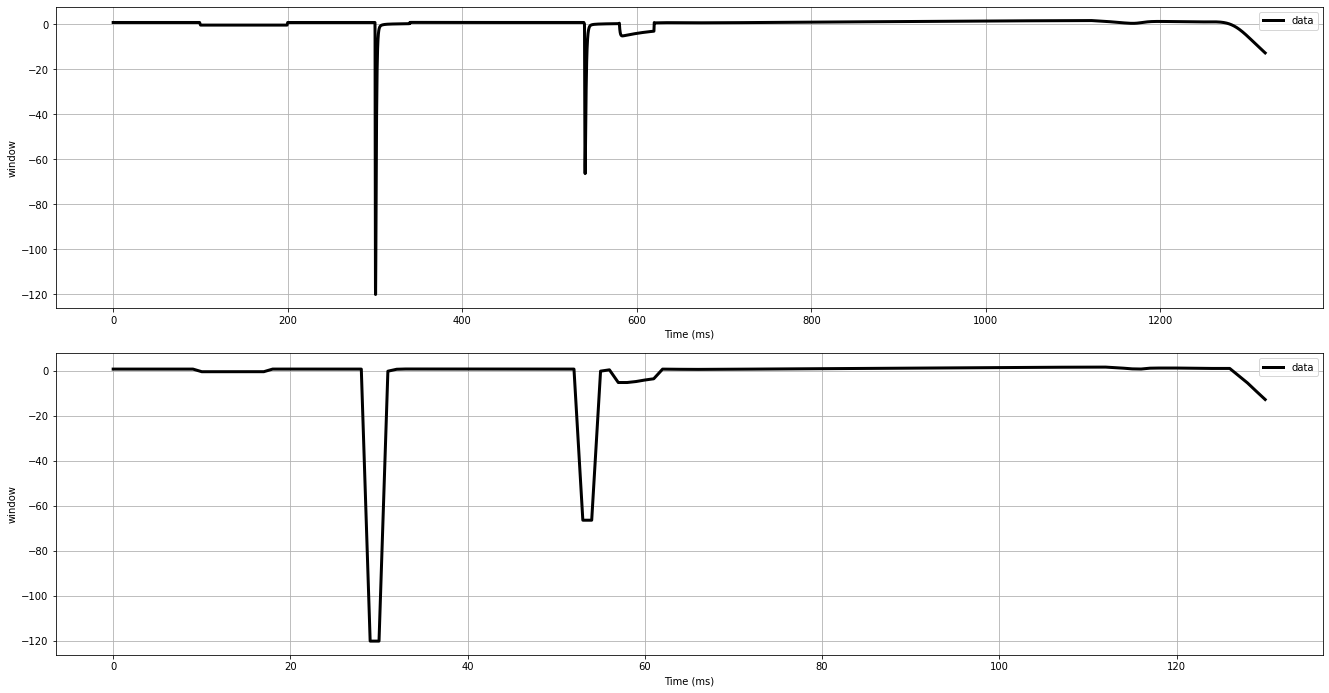

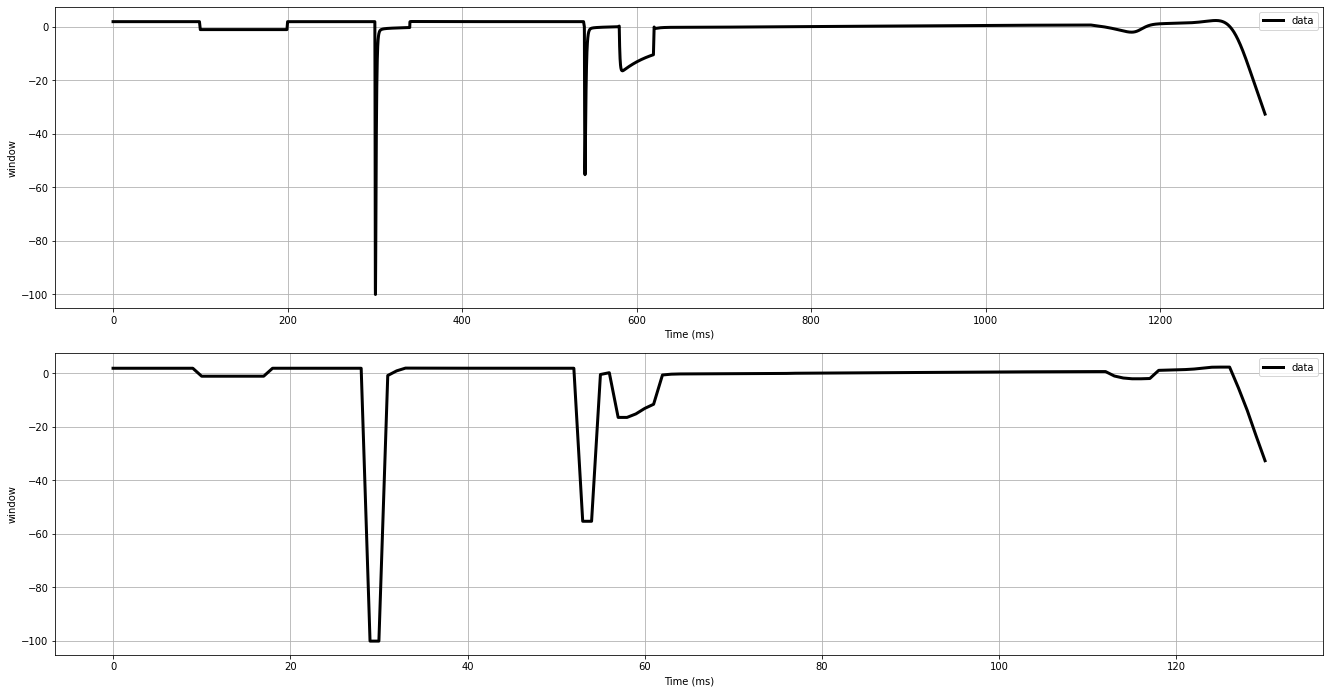

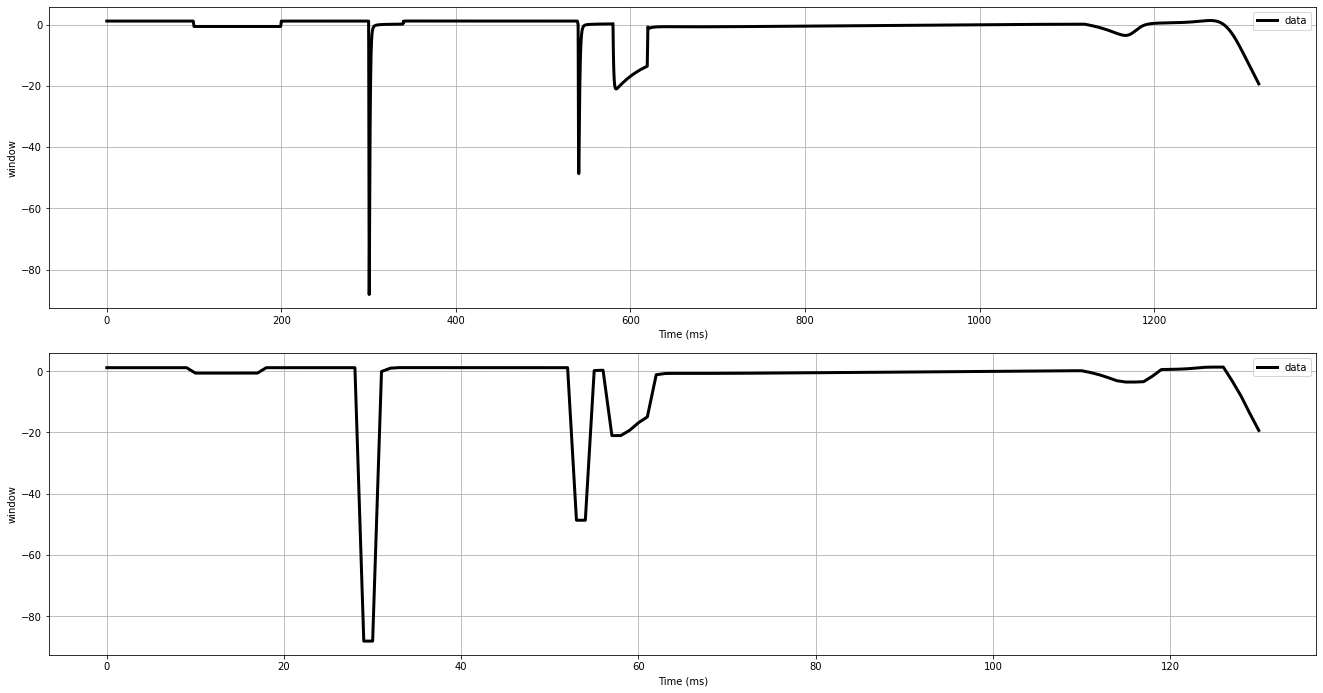

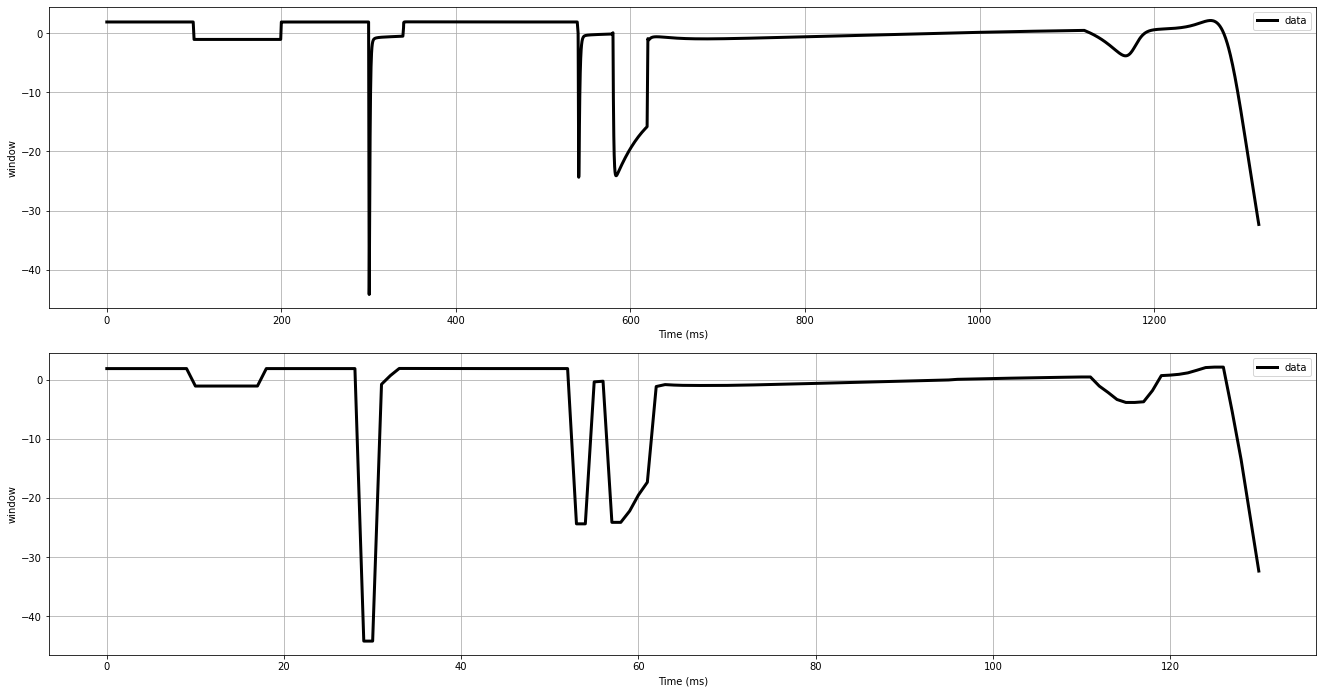

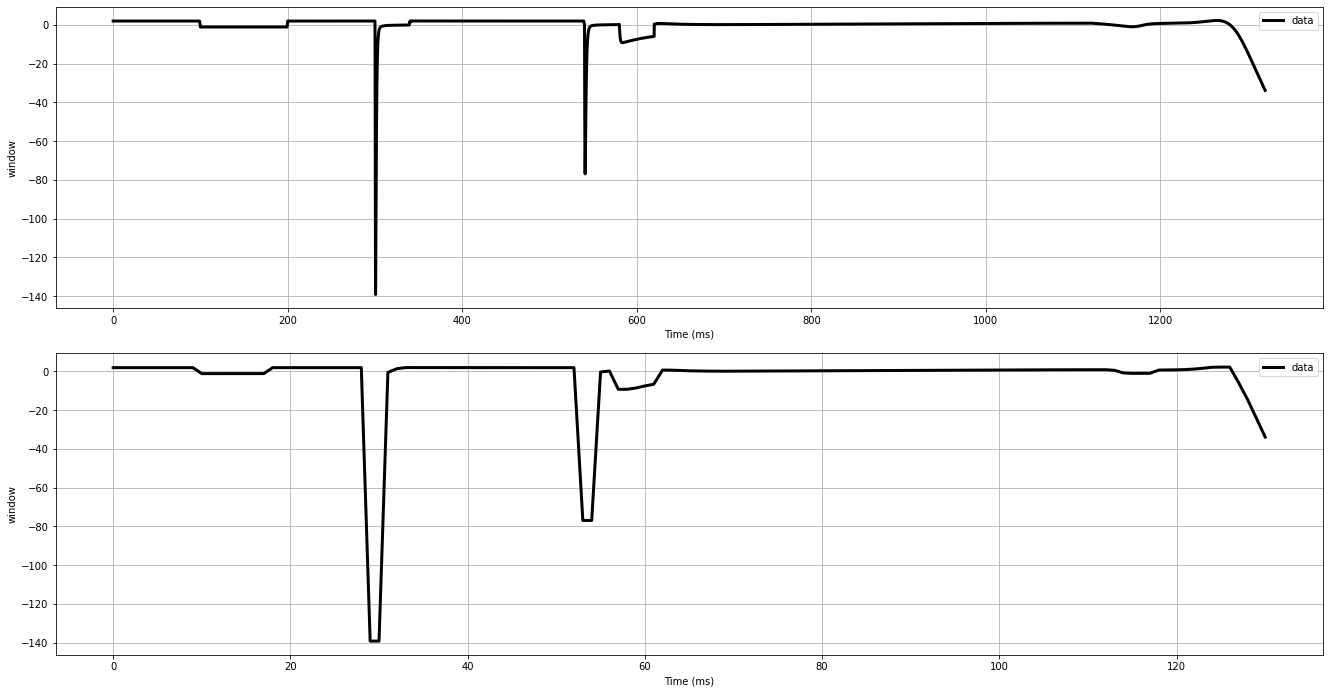

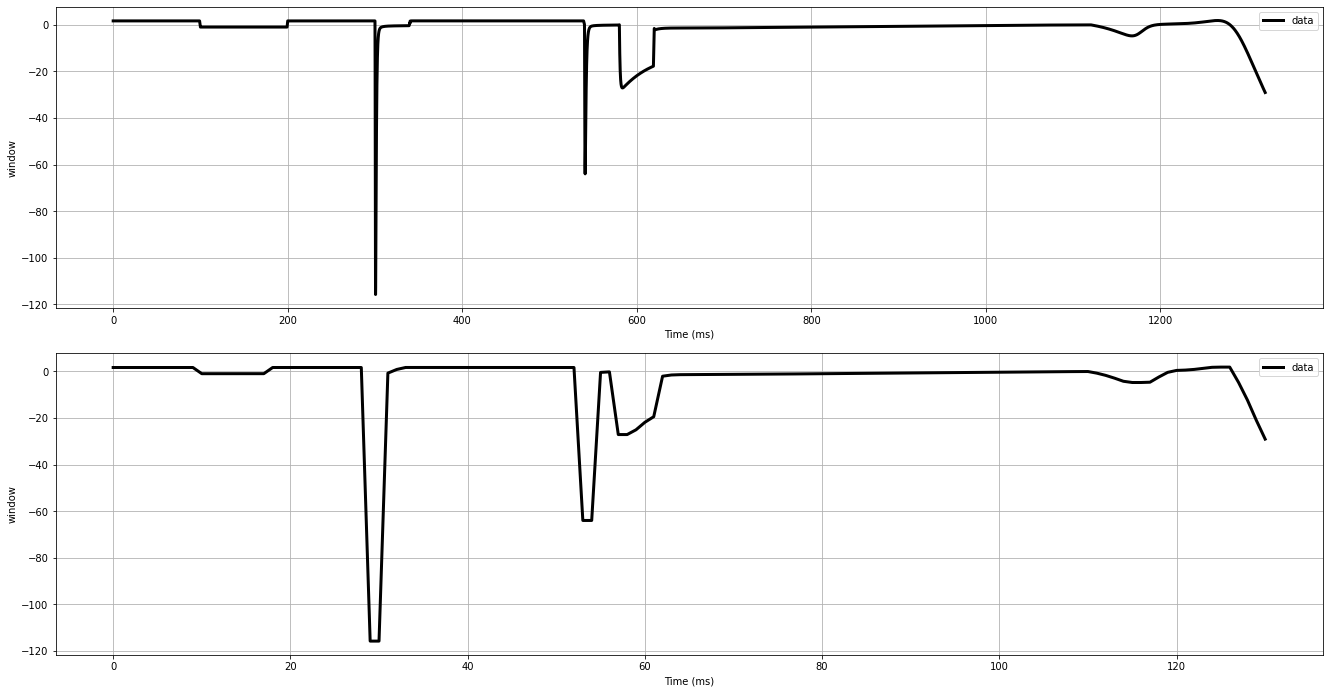

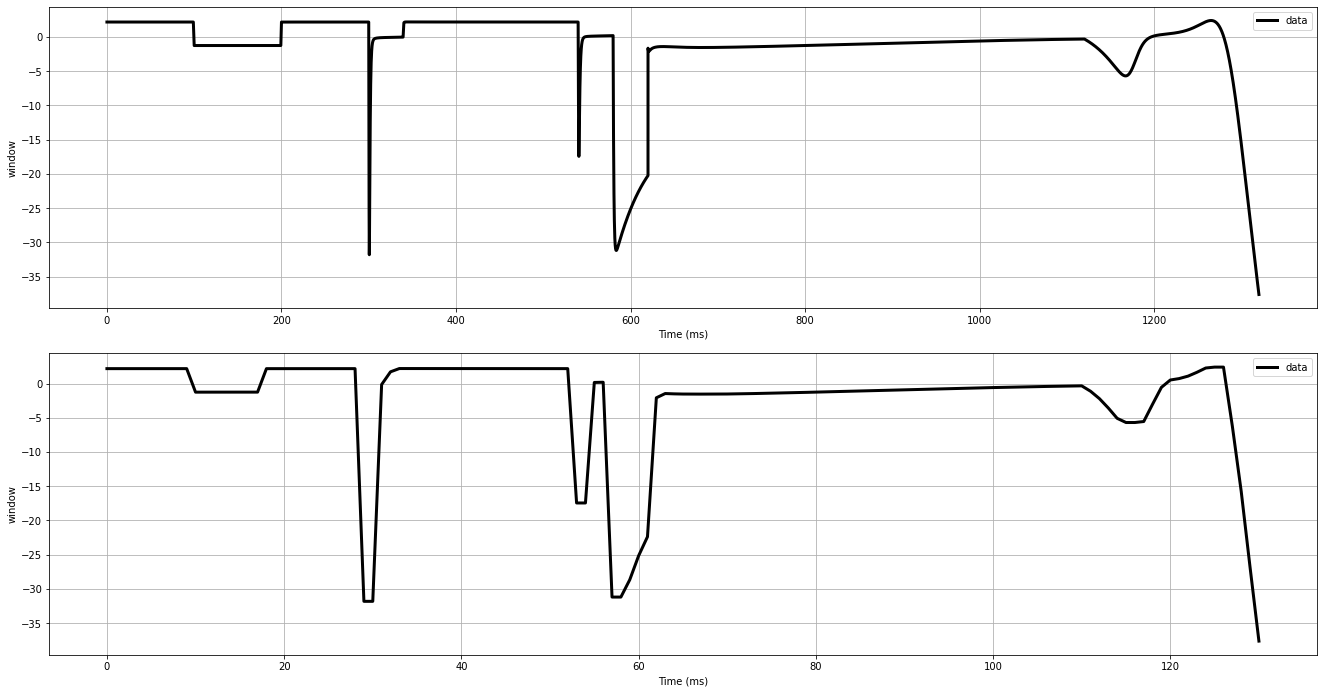

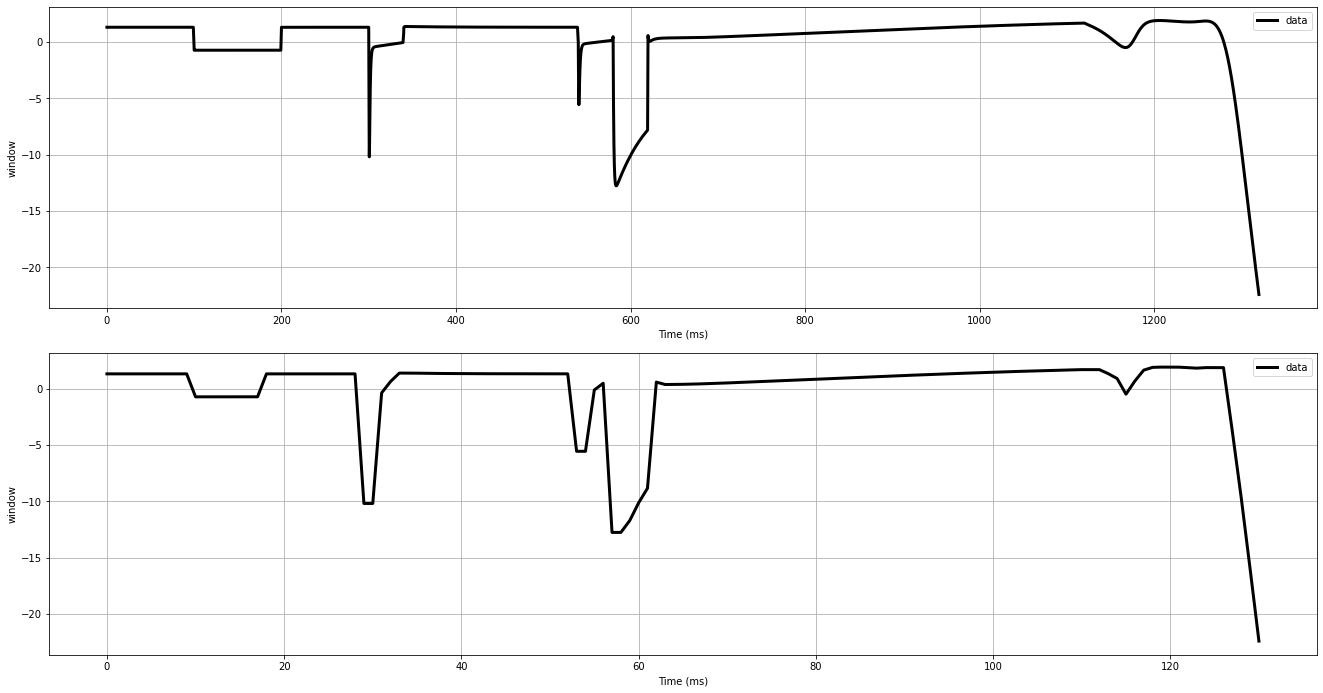

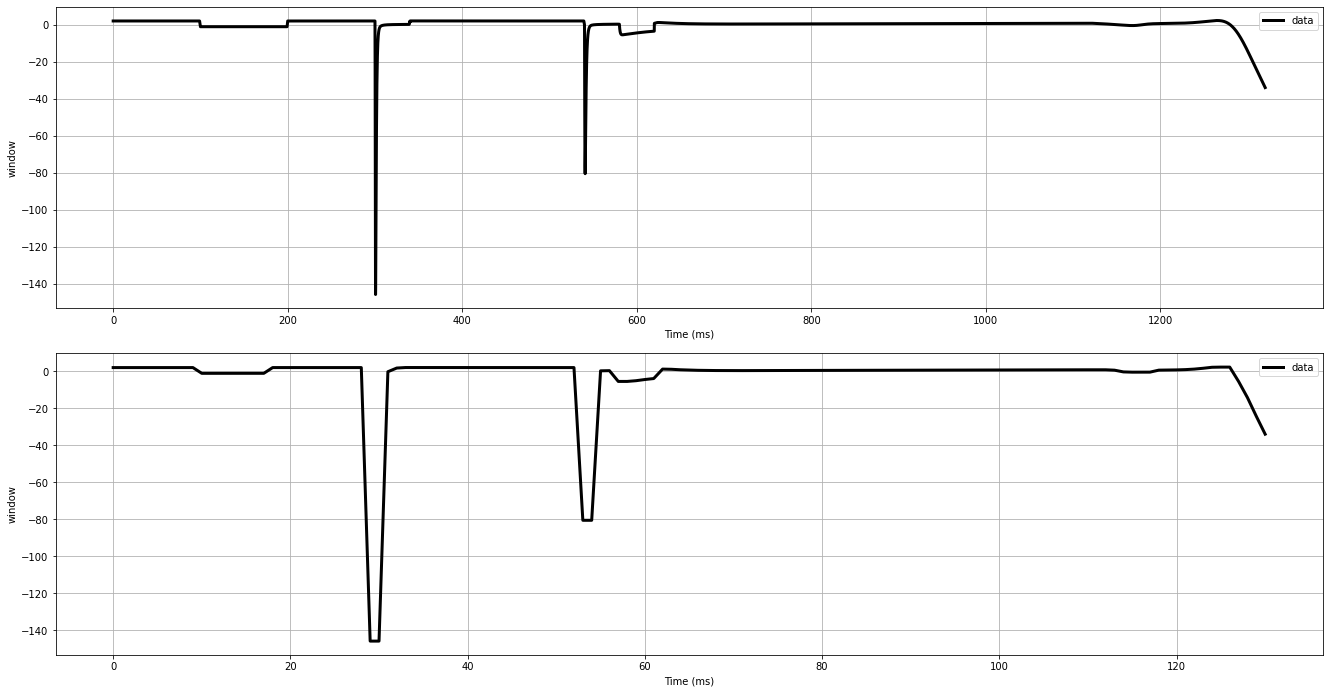

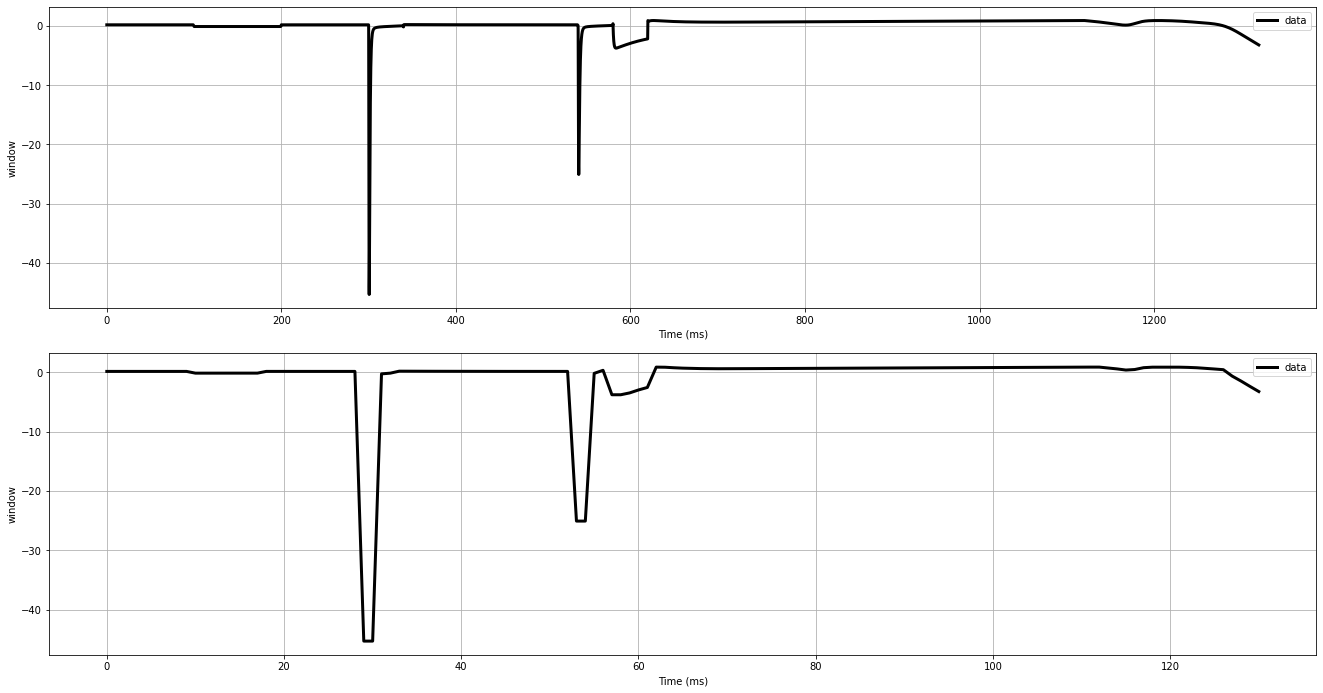

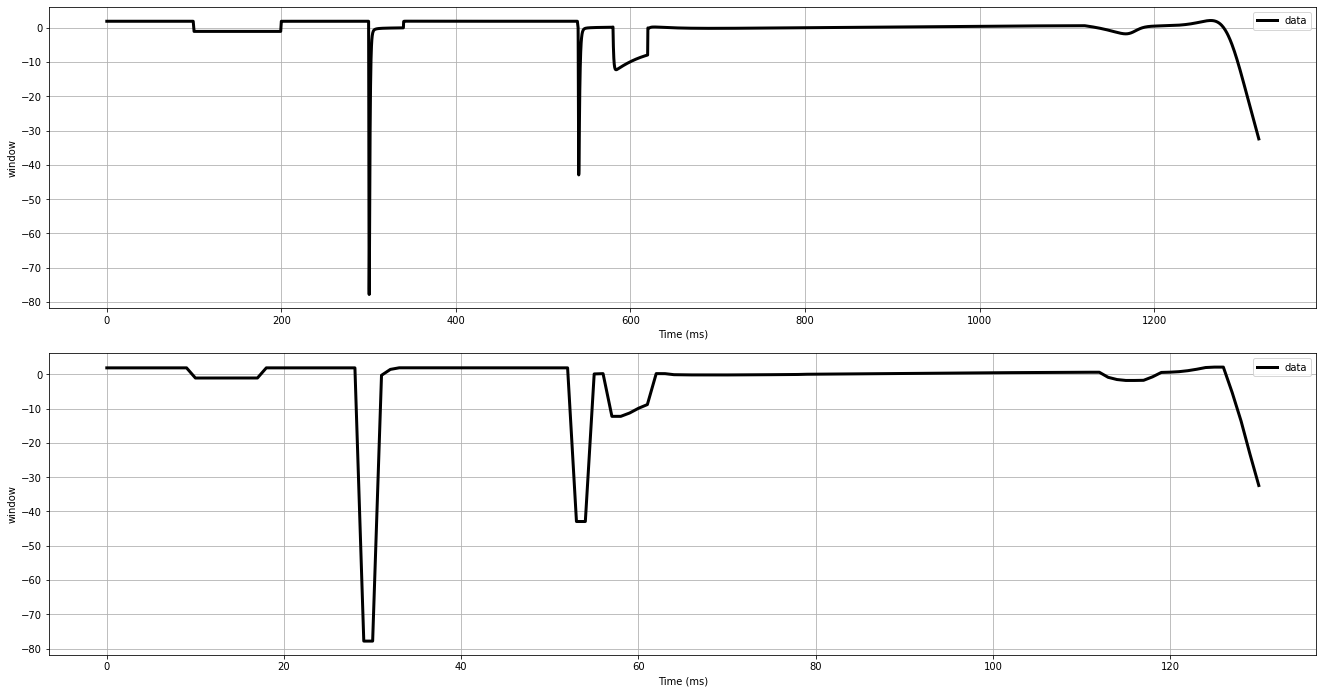

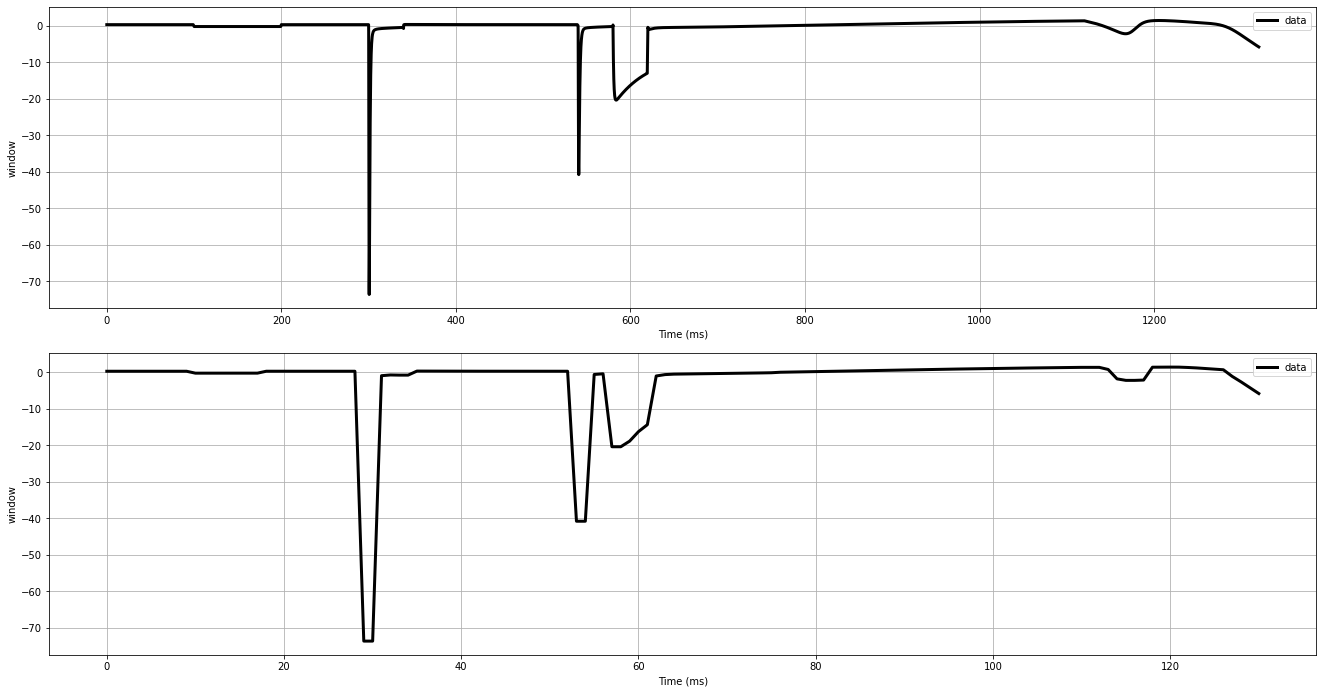

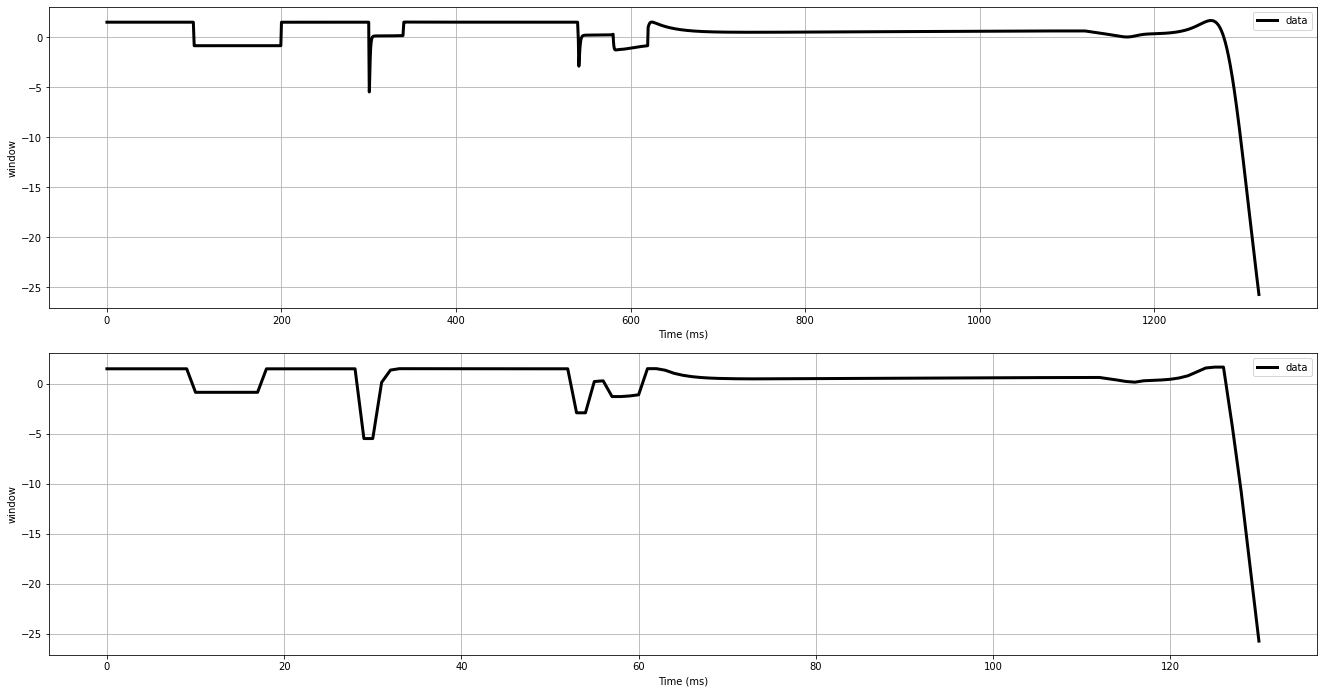

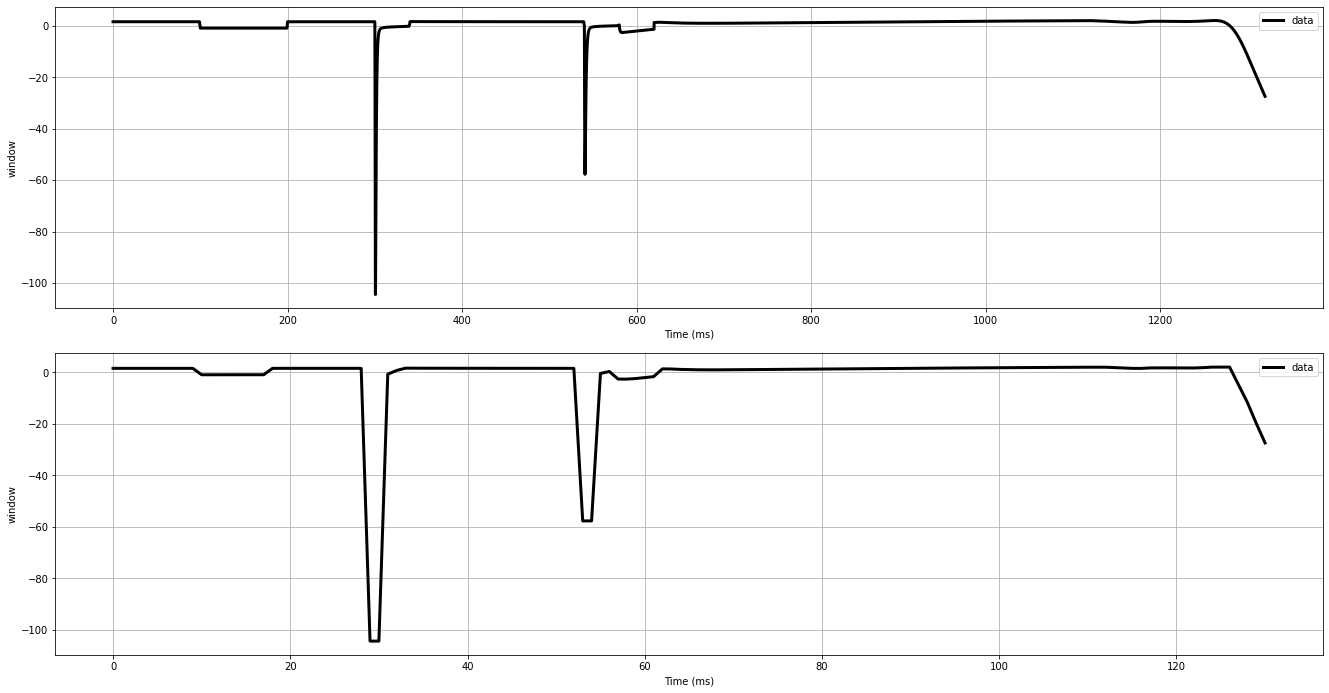

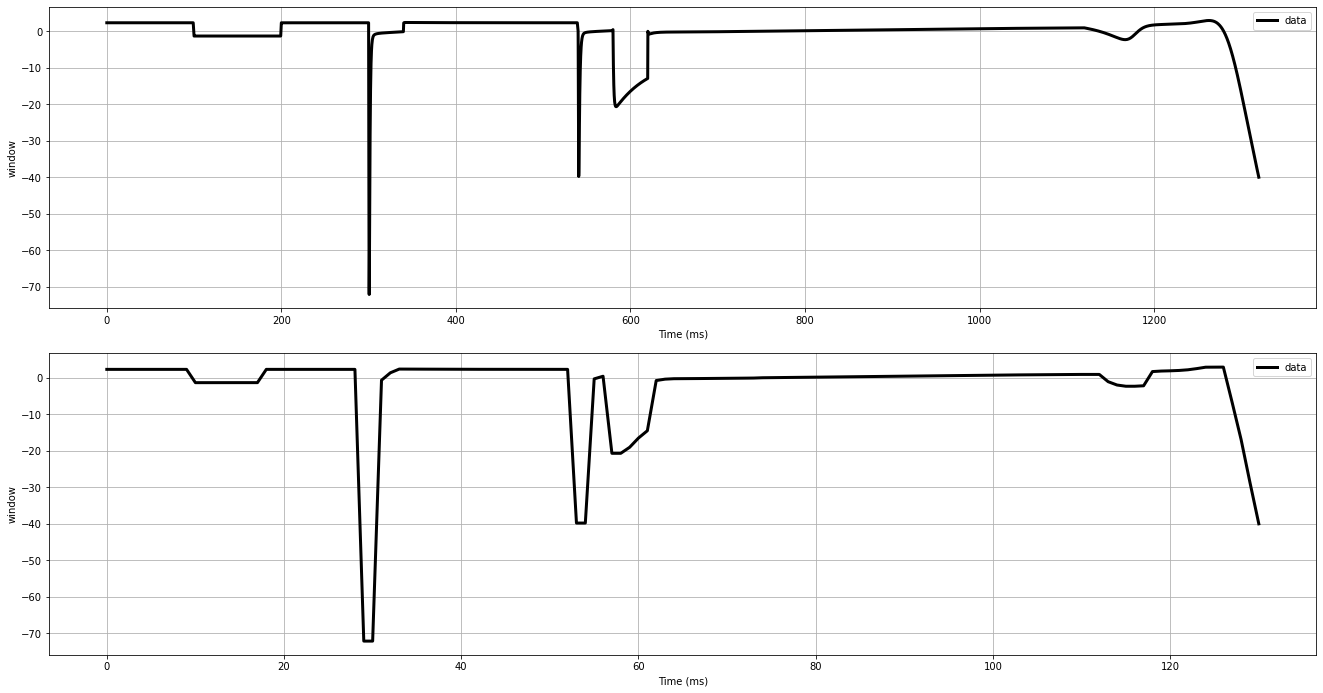

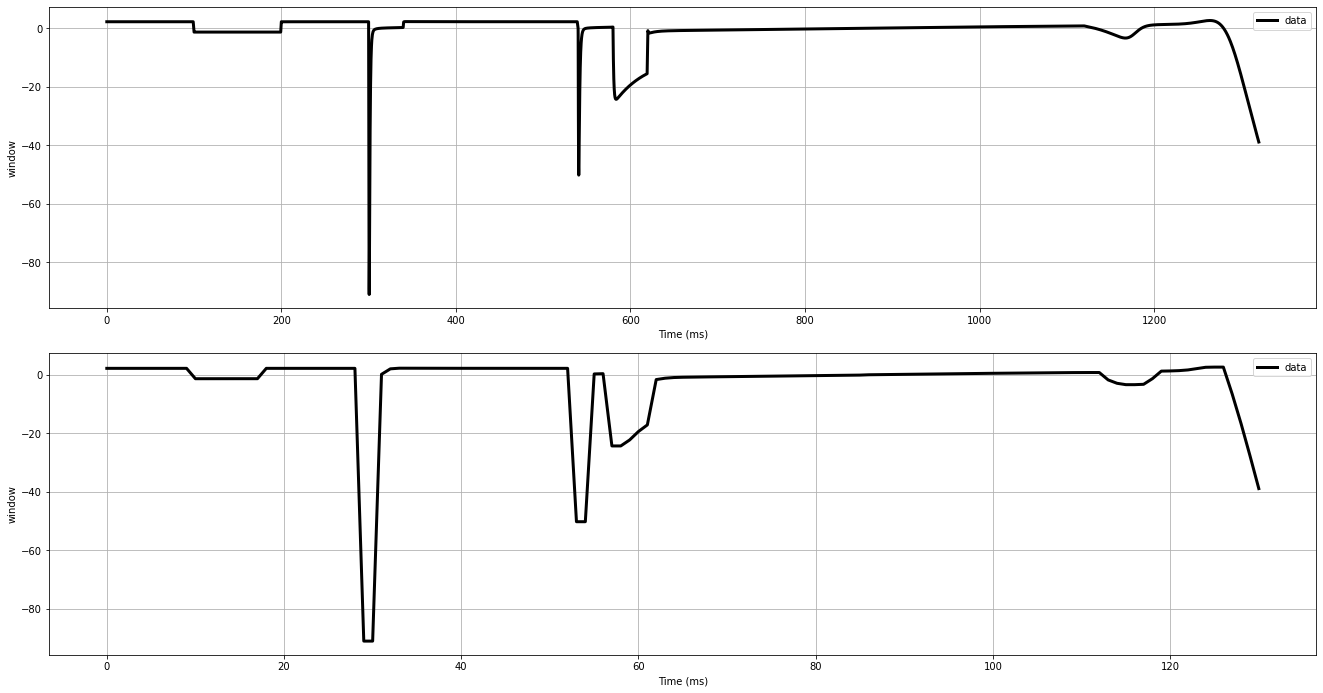

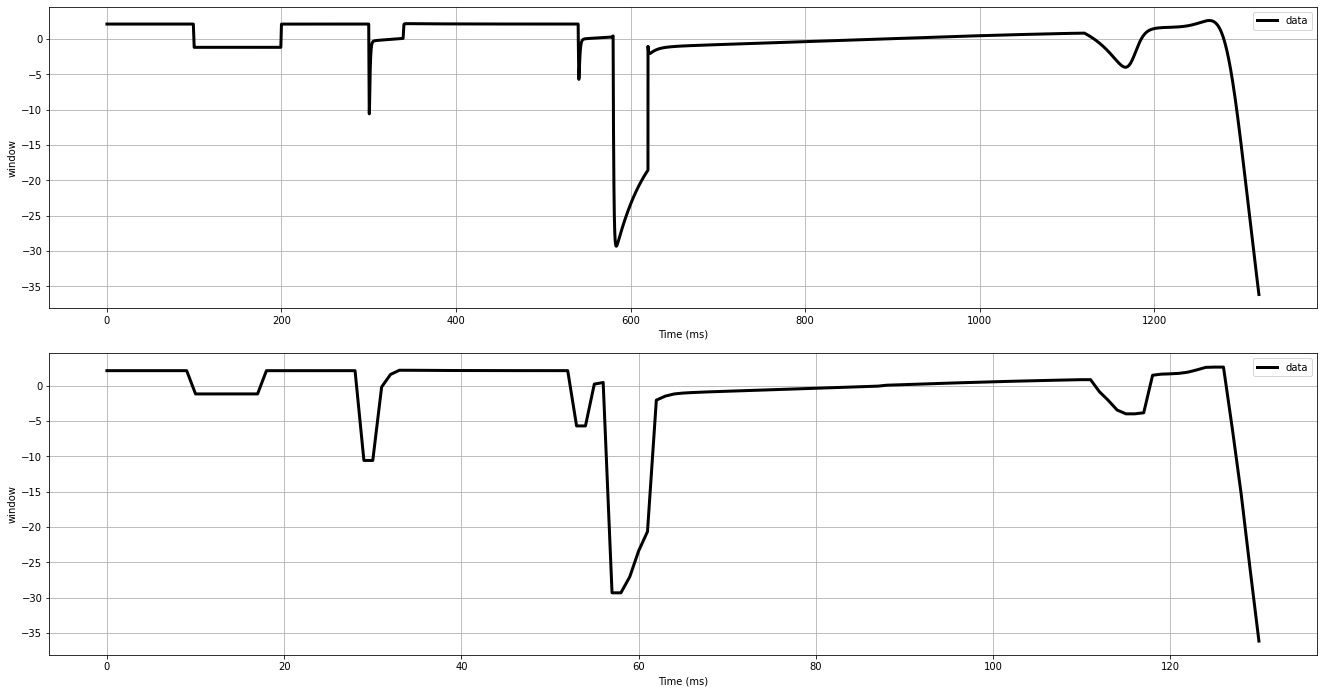

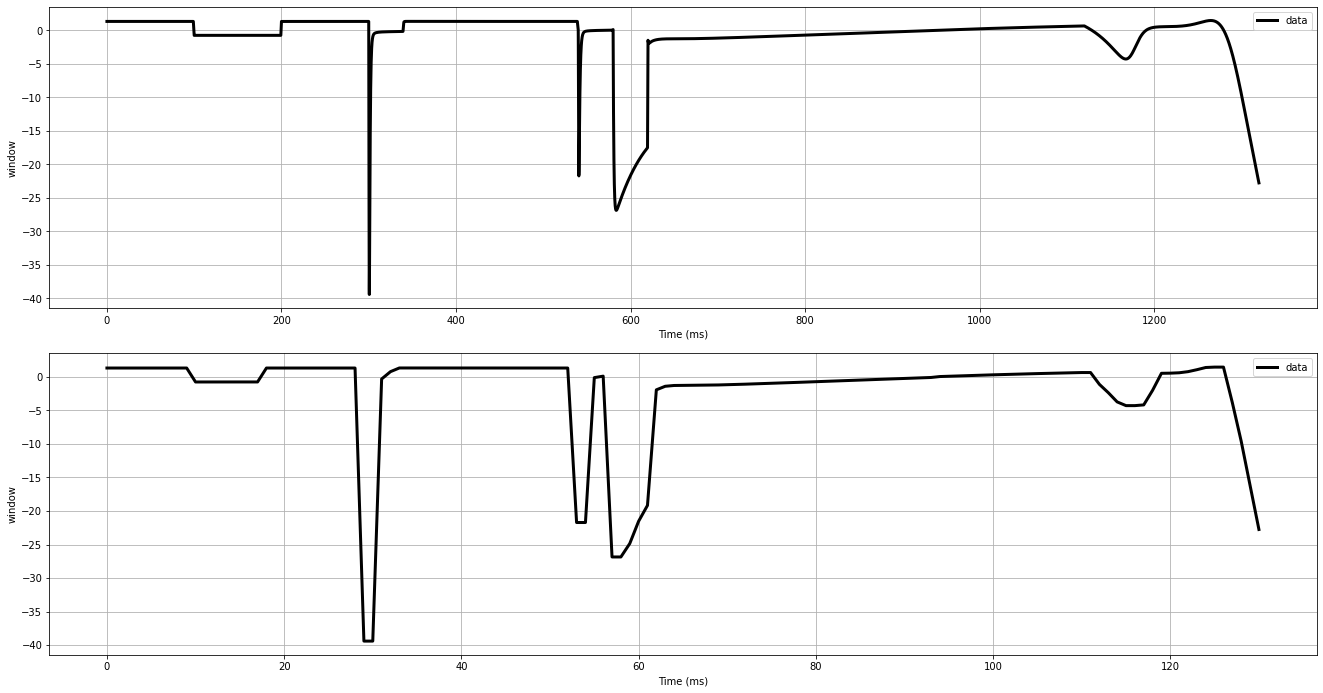

In [21]:
for dataNo in range(20):
    
    sol1 = {}
    sol1["Time"] = xs[dataNo][0]
    sol1["I_ion"] = xs[dataNo][1]
    sol1["window"] = get_currents_with_constant_dt(params=ds_params, x=[sol1["Time"], sol1["I_ion"]])
    y = ys[dataNo]

    # sol1 = pd.DataFrame(data=sol1)
    # sol1.head()
    
    g_adj_li= {
        'ina.g_adj' : y[0],
        'inal.g_adj' : y[1],
        'ito.g_adj' : y[2],
        'ical.g_adj' : y[3],
        'ikr.g_adj' : y[4],
        'iks.g_adj' : y[5],    
        'ik1.g_adj' : y[6],
    } 
    sim.set_simulation_params(g_adj_li)  

    sim.pre_simulate(5000, sim_type=1)
    d = sim.simulate( gen_params['end_time'], extra_log=['membrane.VC', 'membrane.i_ion']+gen_params['log_li'])                           

    sol2 = {}
    sol2["Time"] = d['engine.time']
    # sol2["Voltage"] = d['membrane.VC']
    sol2["I_ion"] = d['membrane.i_ion'] #+ np.random.normal(0, 2, d['membrane.i_ion'].shape) # add noise
    sol2["window"] = get_currents_with_constant_dt(params=ds_params, x=[sol2["Time"], sol2["I_ion"]])
    # sol2["I_Na"] = sim.current_response_info.get_current(['INa'])
    # sol2["I_NaL"] = sim.current_response_info.get_current(['INaL'])
    # sol2["I_To"] = sim.current_response_info.get_current(['Ito'])
    # sol2["I_CaL"] = sim.current_response_info.get_current(['ICaL'])
    # sol2["I_Kr"] = sim.current_response_info.get_current(['IKr'])
    # sol2["I_Ks"] = sim.current_response_info.get_current(['IKs'])
    # sol2["I_K1"] = sim.current_response_info.get_current(['IK1'])
    # sol2 = pd.DataFrame(data=sol2)
    # sol2.head()
    # np.random.normal(0, noise_sigma, current.shape) # add noise
    
    '''
    Plot
    '''
    fig, ax = plt.subplots(2,1, figsize=(20,10))    
    
    ax[0].set_xlabel('Time (ms)')       
    ax[0].set_ylabel(f'{name}')      
    ax[0].plot( sol1['Time'], sol1['I_ion'], label='data', color='k', linewidth=3)     
    # ax[0].plot( sol2['Time'], sol2['I_ion'], label='check', color='r', linewidth=2)    
    ax[0].legend()
    ax[0].grid()
    
    ax[1].set_xlabel('Time (ms)')       
    ax[1].set_ylabel(f'{name}')      
    ax[1].plot( sol1['window'], label='data', color='k', linewidth=3)     
    # ax[1].plot( sol2['window'], label='check', color='r', linewidth=2)    
    ax[1].legend()
    ax[1].grid()
    

    # ax[-1].set_ylim(-5, 5)

    plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)    
    fig.savefig(os.path.join('Test_results', f"{dataNo}.jpg"), dpi=100)
    
# plt.show()    
print("finish")